In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style("whitegrid")
sns.set_palette("muted")
sns.set(font_scale = 1.7)
systems = ['clickhouse', 'duckdb', 'hyper', 'pandas', 'sqlite3']
markers = ['x' for _ in range(len(systems))]

In [4]:
def system_case(s):
    if s == 'duckdb':
        return 'DuckDB'
    elif s == 'clickhouse':
        return 'ClickHouse'
    elif s == 'hyper':
        return 'HyPer'
    elif s == 'pandas':
        return 'Pandas'
    elif s == 'sqlite3':
        return 'SQLite'
    else:
        return s

In [5]:
def collect_randints(systems):
    dfs = []
    for system in systems:
        try:
            df = pd.read_csv(f'../results/{system}/randints/results.csv', header=None, names=['query', 'time'])
            df['system'] = system
            dfs.append(df)
        except:
            None
    result = pd.concat(dfs)
    result.reset_index(inplace=True, drop=True)
    result['system'] = result['system'].apply(lambda s: system_case(s))
    return result

In [6]:
def annotate(ax, systems_and_colors):
    systems = [s for (s, c) in systems_and_colors]
    colors = [c for (s, c) in systems_and_colors]
    for coll, s, c in zip(ax.collections, systems, colors):
        of = coll.get_offsets()[-1]
        label_of = (ax.get_xlim()[1], of[1] - ax.get_ylim()[1] * 0.02)
        ax.annotate(s, label_of, c=c)

In [7]:
randints_df = collect_randints(systems)

asc_desc_df = randints_df[(randints_df['query'] == '100_asc') | (randints_df['query'] == '100_desc') | (randints_df['query'] == '100')]
asc_desc_df = asc_desc_df.groupby(['system', 'query']).median().reset_index().sort_values('system')

randints_df = randints_df[(randints_df['query'] != '100_asc') & (randints_df['query'] != '100_desc')]
randints_df['query'] = pd.to_numeric(randints_df['query'])
randints_df['query'] = randints_df['query'].apply(lambda q: 10 * q)
randints_df = randints_df.groupby(['system', 'query']).median().reset_index().sort_values('system')

In [8]:
systems_and_colors = list(zip(list(randints_df['system'].unique()), sns.color_palette()[:len(systems)]))

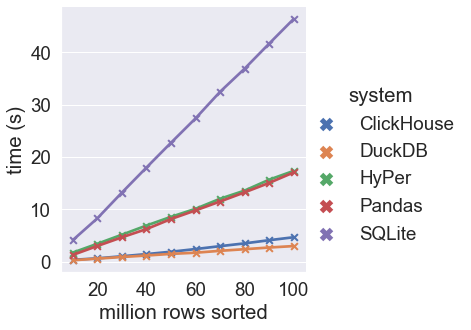

In [9]:
plot = sns.catplot(data=randints_df, kind='point', markers=markers, x='query', y='time', hue='system')
plt.xlabel('million rows sorted')
plt.ylabel('time (s)')
plot.ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda q, pos: f'{10*(q+1)}'))
for lh in plot._legend.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]
for ind, label in enumerate(plot.ax.get_xticklabels()):
    label.set_visible(ind % 2 == 1)
plt.savefig('saved_figs_for_latex/randints_scaling.eps', bbox_inches="tight")

In [10]:
def collect_randints_threads(systems):
    dfs = []
    for system in systems:
        try:
            df = pd.read_csv(f'../results/{system}/randints_threads/results.csv', header=None, names=['threads', 'time'])
            df['system'] = system
            dfs.append(df)
        except:
            None
    result = pd.concat(dfs)
    result.reset_index(inplace=True, drop=True)
    result['system'] = result['system'].apply(lambda s: system_case(s))
    return result

In [11]:
threads_df = collect_randints_threads(['duckdb', 'clickhouse'])
threads_df = threads_df.groupby(['system', 'threads']).median().reset_index().sort_values('system')

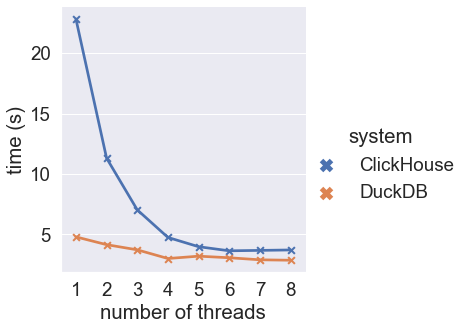

In [12]:
plot = sns.catplot(data=threads_df, kind='point', markers=markers, x='threads', y='time', hue='system')
# plot.ax.set_title('Sorting 100M integers')
plt.xlabel('number of threads')
plt.ylabel('time (s)')
for lh in plot._legend.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]
plt.savefig('saved_figs_for_latex/randints_threads.eps', bbox_inches="tight")

In [13]:
paired = sns.color_palette('Paired')
barplot_colors = paired[7:8] + paired[2:4]

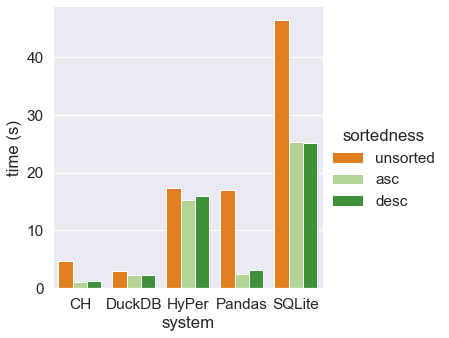

In [14]:
sns.set(font_scale = 1.4)
asc_desc_df['system'] = asc_desc_df['system'].apply(lambda s: 'CH' if s == 'ClickHouse' else s)
plot = sns.catplot(data=asc_desc_df, kind='bar', x='system', y='time', hue='query', palette=sns.color_palette(barplot_colors))
plt.ylabel('time (s)')
# plot.ax.set_title('Sorting 100M integers with different sortedness')
plot._legend.set_title('sortedness')
plot._legend.texts[0].set_text('unsorted')
plot._legend.texts[1].set_text('asc')
plot._legend.texts[2].set_text('desc')
# plot._legend._legend_box.set_offset((320, 225))
plt.savefig('saved_figs_for_latex/randints_sortedness.eps', bbox_inches="tight")

In [15]:
systems = ['clickhouse', 'duckdb', 'hyper', 'pandas']
sfs = [100, 300]

In [16]:
sns.set(font_scale = 1.7)

In [17]:
def collect_tpcds_customer(systems, sfs):
    dfs = []
    for system in systems:
        for sf in sfs:
            try:
                df = pd.read_csv(f'../results/{system}/tpcds/sf{sf}/customer/results.csv', header=None, names=['query', 'time'])
                df['system'] = system
                df['sf'] = sf
                dfs.append(df)
            except:
                None
    result = pd.concat(dfs)
    result.reset_index(inplace=True, drop=True)
    result['system'] = result['system'].apply(lambda s: system_case(s))
    return result

In [18]:
customer_df = collect_tpcds_customer(systems, sfs)

customer_payload_df = customer_df[customer_df['query'].str.contains('payload')]
customer_sort_df = customer_df[customer_df['query'].str.contains('sort')]
customer_df = customer_df[~customer_df['query'].str.contains('payload')]
customer_df = customer_df[~customer_df['query'].str.contains('sort')]

customer_int_df = customer_df[customer_df['query'].str.contains('int')].reset_index(drop=True)
customer_int_df['query'] = customer_int_df['query'].apply(lambda q: q.replace('int', ''))
customer_int_df['query'] = pd.to_numeric(customer_int_df['query'])
customer_int_df = customer_int_df.groupby(['system', 'query', 'sf']).median().reset_index().sort_values('system')

customer_varchar_df = customer_df[customer_df['query'].str.contains('varchar')].reset_index(drop=True)
customer_varchar_df['query'] = customer_varchar_df['query'].apply(lambda q: q.replace('varchar', ''))
customer_varchar_df['query'] = pd.to_numeric(customer_varchar_df['query'])
customer_varchar_df = customer_varchar_df.groupby(['system', 'query', 'sf']).median().reset_index().sort_values('system')

customer_payload_df['query'] = customer_payload_df['query'].apply(lambda q: q.replace('_payload', ''))
customer_payload_df['payload'] = customer_payload_df['query'].apply(lambda q: 'int' if 'int' in q else 'varchar')
customer_payload_df['query'] = customer_payload_df['query'].apply(lambda q: q.replace('int', ''))
customer_payload_df['query'] = customer_payload_df['query'].apply(lambda q: q.replace('varchar', ''))
customer_payload_df['query'] = pd.to_numeric(customer_payload_df['query'])
customer_payload_df = customer_payload_df.groupby(['system', 'query', 'sf', 'payload']).median().reset_index().sort_values('system')
customer_int_payload_df = customer_payload_df[customer_payload_df['payload'] == 'int']
customer_varchar_payload_df = customer_payload_df[customer_payload_df['payload'] == 'varchar']

customer_sort_df['query'] = customer_sort_df['query'].apply(lambda q: q.replace('sort_', ''))
customer_sort_df['query'] = customer_sort_df['query'].apply(lambda q: 'integers' if q == 'ints' else q)
customer_sort_df = customer_sort_df.groupby(['system', 'query', 'sf']).median().reset_index().sort_values('system')

In [19]:
# plot = sns.catplot(data=customer_int_df, col='sf', kind='point', markers=markers, x='query', y='time', hue='system', sharey=False, sharex=True, col_wrap=2)
# for i, ax in enumerate(plot.axes):
#     ax.set_ylabel('time (s)')
#     if i % 2 == 1:
#         ax.set_ylabel('')
#     if i > 1:
#         ax.set_xlabel('number of order clauses')
#     else:
#         ax.set_xlabel('')
# for lh in plot._legend.legendHandles:
#     lh._sizes = [100]
#     lh._linewidths = [5]
# plot.fig.subplots_adjust(top=0.9)
# plot.fig.suptitle('TPCDS customer table ordered by an increasing number of integer columns')
# plt.savefig('saved_figs_for_latex/tpcds_customer_int.eps', bbox_inches="tight")

In [20]:
# plot = sns.catplot(data=customer_varchar_df, col='sf', kind='point', markers=markers, x='query', y='time', hue='system', sharey=False, sharex=True, col_wrap=2)
# for i, ax in enumerate(plot.axes):
#     ax.set_ylabel('time (s)')
#     if i % 2 == 1:
#         ax.set_ylabel('')
#     if i > 1:
#         ax.set_xlabel('number of order clauses')
#     else:
#         ax.set_xlabel('')
# for lh in plot._legend.legendHandles:
#     lh._sizes = [100]
#     lh._linewidths = [5]
# plot.fig.subplots_adjust(top=0.9)
# plot.fig.suptitle('TPCDS customer table ordered by an increasing number of string columns')
# plt.savefig('saved_figs_for_latex/tpcds_customer_string.eps', bbox_inches="tight")

In [21]:
customer_payload_df = customer_payload_df[(customer_payload_df['payload'] == 'int') & (customer_payload_df['query'] == 10) | (customer_payload_df['payload'] == 'varchar') & (customer_payload_df['query'] == 8)]
customer_payload_df = customer_payload_df.sort_values(['payload'])

In [22]:
barplot_colors = [barplot_colors[0], barplot_colors[2]]

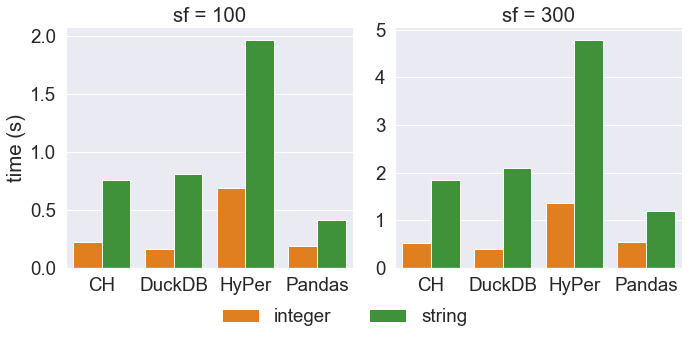

In [23]:
customer_payload_df['system'] = customer_payload_df['system'].apply(lambda s: 'CH' if s == 'ClickHouse' else s)
plot = sns.catplot(data=customer_payload_df, col='sf', kind='bar', x='system', y='time', hue='payload', sharey=False, sharex=False, col_wrap=2, palette=sns.color_palette(barplot_colors))
for i, ax in enumerate(plot.axes):
    ax.set_ylabel('time (s)')
    if i % 2 == 1:
        ax.set_ylabel('')
    if i > 1:
        ax.set_xlabel('system')
    else:
        ax.set_xlabel('')
# for lh in plot._legend.legendHandles:
#     lh._sizes = [100]
#     lh._linewidths = [5]
# plot.fig.subplots_adjust(top=0.825)
# plot.fig.suptitle('customer ordered by different column types: birth date (int) or full name (string)')
# c_birth_year, c_birth_month, c_birth_day and c_first_name, c_last_name
# plot._legend.set_title('sort type')
# plot._legend._legend_box.set_offset((720, 180))

plot._legend.set_visible(False)
handles, labels = plot.axes[0].get_legend_handles_labels()
labels[0] = 'integer'
labels[1] = 'string'
lgnd = plot.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=len(labels), frameon=False)
plot.fig.subplots_adjust(bottom=0.215)
for lh in lgnd.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]

plt.savefig('saved_figs_for_latex/tpcds_customer_type_payload_barplot.eps', bbox_inches="tight")

In [24]:
# plot = sns.catplot(data=customer_int_payload_df, col='sf', kind='point', markers=markers, x='query', y='time', hue='system', sharey=False, sharex=True, col_wrap=2)
# for i, ax in enumerate(plot.axes):
#     ax.set_ylabel('time (s)')
#     if i % 2 == 1:
#         ax.set_ylabel('')
#     if i > 1:
#         ax.set_xlabel('number of payload columns')
#     else:
#         ax.set_xlabel('')
# for lh in plot._legend.legendHandles:
#     lh._sizes = [100]
#     lh._linewidths = [5]
# plot.fig.subplots_adjust(top=0.9)
# plot.fig.suptitle('TPCDS customer integer columns ordered by birth date')
# plt.savefig('saved_figs_for_latex/tpcds_customer_int_payload.eps', bbox_inches="tight")

In [25]:
# plot = sns.catplot(data=customer_varchar_payload_df, col='sf', kind='point', markers=markers, x='query', y='time', hue='system', sharey=False, sharex=True, col_wrap=2)
# for i, ax in enumerate(plot.axes):
#     ax.set_ylabel('time (s)')
#     if i % 2 == 1:
#         ax.set_ylabel('')
#     if i > 1:
#         ax.set_xlabel('number of payload columns')
#     else:
#         ax.set_xlabel('')
# for lh in plot._legend.legendHandles:
#     lh._sizes = [100]
#     lh._linewidths = [5]
# plot.fig.subplots_adjust(top=0.9)
# plot.fig.suptitle('TPCDS customer string columns ordered by birth date')
# plt.savefig('saved_figs_for_latex/tpcds_customer_varchar_payload.eps', bbox_inches="tight")

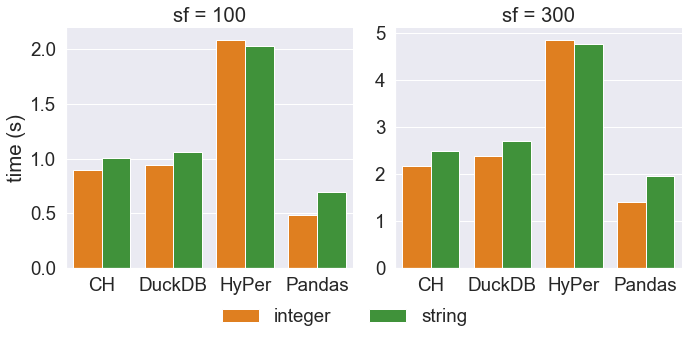

In [26]:
customer_sort_df['system'] = customer_sort_df['system'].apply(lambda s: 'CH' if s == 'ClickHouse' else s)
plot = sns.catplot(data=customer_sort_df, col='sf', kind='bar', x='system', y='time', hue='query', sharey=False, sharex=False, col_wrap=2, palette=barplot_colors)
for i, ax in enumerate(plot.axes):
    ax.set_ylabel('time (s)')
    if i % 2 == 1:
        ax.set_ylabel('')
    if i > 1:
        ax.set_xlabel('system')
    else:
        ax.set_xlabel('')

plot._legend.set_visible(False)
handles, labels = plot.axes[0].get_legend_handles_labels()
labels[0] = 'integer'
labels[1] = 'string'
lgnd = plot.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=len(labels), frameon=False)
plot.fig.subplots_adjust(bottom=0.215)
for lh in lgnd.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]
    
plt.savefig('saved_figs_for_latex/tpcds_customer_type_sort_barplot.eps', bbox_inches="tight")

In [27]:
sfs = [10, 100]

In [28]:
def collect_tpcds_catalog_sales(systems, sfs):
    dfs = []
    for system in systems:
        for sf in sfs:
            try:
                df = pd.read_csv(f'../results/{system}/tpcds/sf{sf}/catalog_sales/results.csv', header=None, names=['query', 'time'])
                df['system'] = system
                df['sf'] = sf
                dfs.append(df)
            except:
                None
    result = pd.concat(dfs)
    result.reset_index(inplace=True, drop=True)
    result['system'] = result['system'].apply(lambda s: system_case(s))
    return result

In [29]:
catalog_sales_df = collect_tpcds_catalog_sales(systems, sfs)

catalog_sales_payload_df = catalog_sales_df[catalog_sales_df['query'].str.contains('payload')].reset_index(drop=True)
catalog_sales_payload_df['query'] = catalog_sales_payload_df['query'].apply(lambda q: q.replace('payload', ''))
catalog_sales_payload_df['query'] = pd.to_numeric(catalog_sales_payload_df['query'])
catalog_sales_payload_df = catalog_sales_payload_df.groupby(['system', 'query', 'sf']).median().reset_index().sort_values('system')

catalog_sales_sorting_df = catalog_sales_df[catalog_sales_df['query'].str.contains('sorting')].reset_index(drop=True)
catalog_sales_sorting_df['query'] = catalog_sales_sorting_df['query'].apply(lambda q: q.replace('sorting', ''))
catalog_sales_sorting_df['query'] = pd.to_numeric(catalog_sales_sorting_df['query'])
catalog_sales_sorting_df = catalog_sales_sorting_df.groupby(['system', 'query', 'sf']).median().reset_index().sort_values('system')

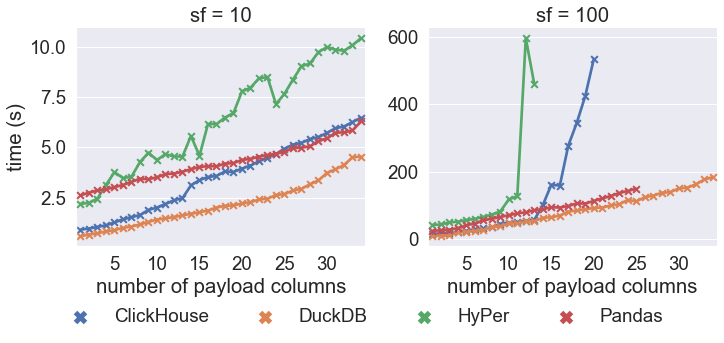

In [30]:
sns.set(font_scale = 1.7)

plot = sns.catplot(data=catalog_sales_payload_df, col='sf', kind='point', markers=markers, x='query', y='time', hue='system', sharey=False, sharex=True, col_wrap=2,
                  height=5, aspect=0.8)
for i, ax in enumerate(plot.axes):
    ax.set_ylabel('time (s)')
    if i > 0:
        ax.set_ylabel('')
    ax.set_xlabel('number of payload columns')
    for ind, label in enumerate(ax.get_xticklabels()):
        label.set_visible(ind % 5 == 4)
for lh in plot._legend.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]

plt.tight_layout()
    
plot._legend.set_bbox_to_anchor((0.5, 0.5))
plot._legend.set_visible(False)
handles, labels = plot.axes[0].get_legend_handles_labels()
lgnd = plot.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=len(labels), frameon=False)
plot.fig.subplots_adjust(bottom=0.275)
for lh in lgnd.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]

# plot._legend.set_title('sortedness')
# plot.fig.subplots_adjust(top=0.825)
# plot.fig.suptitle('catalog_sales ordered by cs_quantity, cs_item_sk')
plt.savefig('saved_figs_for_latex/tpcds_catalog_sales_payload.eps', bbox_inches="tight")

In [31]:
# plot = sns.catplot(data=catalog_sales_sorting_df, col='sf', kind='point', markers=markers, x='query', y='time', hue='system', sharey=False, sharex=True, col_wrap=2)
# for i, ax in enumerate(plot.axes):
#     ax.set_ylabel('time (s)')
#     if i > 0:
#         ax.set_ylabel('')
#     ax.set_xlabel('number of order clauses')
# for lh in plot._legend.legendHandles:
#     lh._sizes = [100]
#     lh._linewidths = [5]
# plot.fig.subplots_adjust(top=0.825)
# plot.fig.suptitle('TPCDS catalog_sales table ordered by an increasing number of columns')
# plt.savefig('saved_figs_for_latex/tpcds_catalog_sales_sorting.eps', bbox_inches="tight")

In [32]:
def collect_tpcds_catalog_sales_jewels(systems, sfs):
    dfs = []
    for system in systems:
        try:
            df = pd.read_csv(f'../results/jewels07/{system}_results.csv', header=None, names=['query', 'time'])
            df['system'] = system
            df['sf'] = 100
            dfs.append(df)
        except:
            None
    result = pd.concat(dfs)
    result.reset_index(inplace=True, drop=True)
    result['system'] = result['system'].apply(lambda s: system_case(s))
    return result

In [33]:
jewels_df = collect_tpcds_catalog_sales_jewels(systems, sfs)
jewels_df = jewels_df[jewels_df['query'].str.contains('payload')].reset_index(drop=True)
jewels_df['query'] = jewels_df['query'].apply(lambda q: q.replace('payload', ''))
jewels_df['query'] = pd.to_numeric(jewels_df['query'])
jewels_df = jewels_df.groupby(['system', 'query', 'sf']).median().reset_index().sort_values('system')

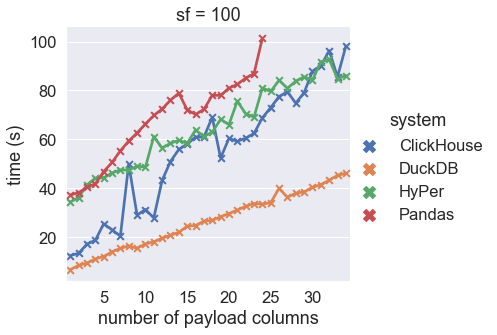

In [34]:
sns.set(font_scale = 1.5)
plot = sns.catplot(data=jewels_df, col='sf', kind='point', markers=markers, x='query', y='time', hue='system', sharey=False, sharex=True, col_wrap=1,
                  height=5, aspect=1.1)
for i, ax in enumerate(plot.axes):
    ax.set_ylabel('time (s)')
    if i % 2 == 1:
        ax.set_ylabel('')
    ax.set_xlabel('number of payload columns')
    for ind, label in enumerate(ax.get_xticklabels()):
        label.set_visible(ind % 5 == 4)
for lh in plot._legend.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]
# plot.fig.subplots_adjust(top=0.85)
# plot.fig.suptitle('x86: catalog_sales ordered by cs_quantity, cs_item_sk')
plt.savefig('saved_figs_for_latex/jewels_payload.eps', bbox_inches="tight")